### Using SciBERT as classifier and SBERT for sentence retrieval
Considering all the documents for checking the claim may overshadow relevant information due to presence of a lot of irrelevant information.

So intially sentence retrieval part is done by Sentence-BERT(SBERT) which encodes contextualized representations of evidence sentences and rank them by cosine similarity to the claim.

Then top_k sentences are sent as input for the SciBERT classifier.

In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import regex as re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import plotly.express as px
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
!pip install sentence-transformers

### Preparing Dataset and sentence retrieval part

In [2]:
from sentence_transformers import SentenceTransformer, util

In [3]:
stop_words = set(stopwords.words('english'))

In [12]:
file_paths = {
        "train": "train.tsv",
        "test": "test.tsv",
        "valid": "dev.tsv"
    }

In [13]:
def read_data(file_path):
    df = pd.read_csv(file_path, sep='\t')
    df = df[['claim', 'main_text', 'label']]
    df.dropna(axis=0, inplace=True)

    def preprocess_text(text):
        text = re.sub(r'[#\\\"$”“,:()–’\'/;\[\]{}—‘!+•%&-]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.lower()
        return ' '.join([word for word in word_tokenize(text) if word not in stop_words])

    df['main_text'] = df['main_text'].apply(preprocess_text)
    df['claim'] = df['claim'].apply(preprocess_text)

    df = df[df['label'].str.contains('snopes') == False]
    label_dict = {'true': 0, 'false': 1, 'mixture': 2, 'unproven': 3}
    df['label'] = df['label'].map(label_dict)
    return df

In [14]:
def retrieve_top_k_sentences(claim, main_text, k=3, model=None):

    sentences = nltk.sent_tokenize(main_text)
    if model is None:
        raise ValueError("A SentenceTransformer model must be provided")
    claim_embedding = model.encode(claim, convert_to_tensor=True)
    sentence_embeddings = model.encode(sentences, convert_to_tensor=True)
    similarities = util.cos_sim(claim_embedding, sentence_embeddings)[0]
    top_k_indices = similarities.argsort(descending=True)[:k]
    return ' '.join([sentences[i] for i in top_k_indices])

In [15]:
def load_and_preprocess_data(file_paths, sbert_model):
    datasets = {}
    for key, path in file_paths.items():
        df = read_data(path)
        df['top_k_sentences'] = df.apply(
            lambda row: retrieve_top_k_sentences(row['claim'], row['main_text'], model=sbert_model), axis=1
        )
        datasets[key] = df
    return datasets

In [10]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
datasets = load_and_preprocess_data(file_paths, sbert_model)

In [17]:
def tokenize_data(data, tokenizer):
    return tokenizer(
        data["claim"].tolist(),
        data["top_k_sentences"].tolist(),
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

In [ ]:
class PUBHEALTHDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        # Store encodings and labels as tensors
        labels = [int(label) if isinstance(label, float) else int(label) for label in labels]
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.encodings = encodings

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Use clone().detach() instead of torch.tensor() for existing tensors
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx].clone().detach()
        return item

In [ ]:
def prepare_datasets(datasets, tokenizer):
    tokenized_datasets = {}

    for key, df in datasets.items():
        df = df.dropna(subset=["label"])

        encodings = tokenize_data(df, tokenizer)
        tokenized_datasets[key] = PUBHEALTHDataset(encodings, df["label"].tolist())

    return tokenized_datasets

### Model training functions

In [29]:
from sklearn.utils.class_weight import compute_class_weight
# Calculate class weights based on training labels
def calculate_class_weights(dataset):
    labels = dataset['label'].values
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(labels),
        y=labels
    )
    return torch.tensor(class_weights, dtype=torch.float)

In [30]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device)  # Move weights to GPU/CPU

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights)  # Use weighted loss
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [39]:
def train_model_with_weights(train_dataset, valid_dataset, model):
    # Calculate class weights
    class_weights = calculate_class_weights(datasets["train"])  # Using the train dataset

    # Define training arguments
    training_args = TrainingArguments(eval_strategy="epoch",
        output_dir="./results",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=1,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        save_strategy="epoch",
    )

    # Initialize the custom weighted trainer
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset = valid_dataset,
        class_weights=class_weights
    )

    trainer.train()
    return trainer

In [42]:
torch.cuda.empty_cache()

In [20]:
def evaluate_model(true_labels, predicted_labels, label_mapping):
    reverse_mapping = {v: k for k, v in label_mapping.items()}
    true_labels_str = [reverse_mapping[label] for label in true_labels]
    predicted_labels_str = [reverse_mapping[label] for label in predicted_labels]

    print("Classification Report:\n", classification_report(true_labels_str, predicted_labels_str))
    cm = confusion_matrix(true_labels_str, predicted_labels_str, labels=list(label_mapping.keys()))
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [21]:
def evaluate_model_performance(trainer, test_dataset, test_labels, label_mapping):
    predictions = trainer.predict(test_dataset)
    predicted_labels = predictions.predictions.argmax(axis=1)
    evaluate_model(test_labels, predicted_labels, label_mapping)

In [22]:
def train_model(train_dataset, valid_dataset, model):
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
    )
    trainer.train()
    return trainer

In [40]:
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [25]:
label_map = {
    'true': 0,
    'false': 1,
    'mixture': 2,
    'unproven': 3
}

tokenized_datasets = prepare_datasets(datasets, tokenizer)

### Training model and Results

In [26]:

trainer = train_model(
        tokenized_datasets["train"],
        tokenized_datasets["valid"],
        model
    )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.773000,0.710532
2,0.676900,0.694732
3,0.552800,0.730942


Classification Report:
               precision    recall  f1-score   support

       false       0.58      0.77      0.67       388
     mixture       0.44      0.21      0.28       201
        true       0.79      0.81      0.80       599
    unproven       0.36      0.11      0.17        45

    accuracy                           0.67      1233
   macro avg       0.54      0.47      0.48      1233
weighted avg       0.65      0.67      0.65      1233



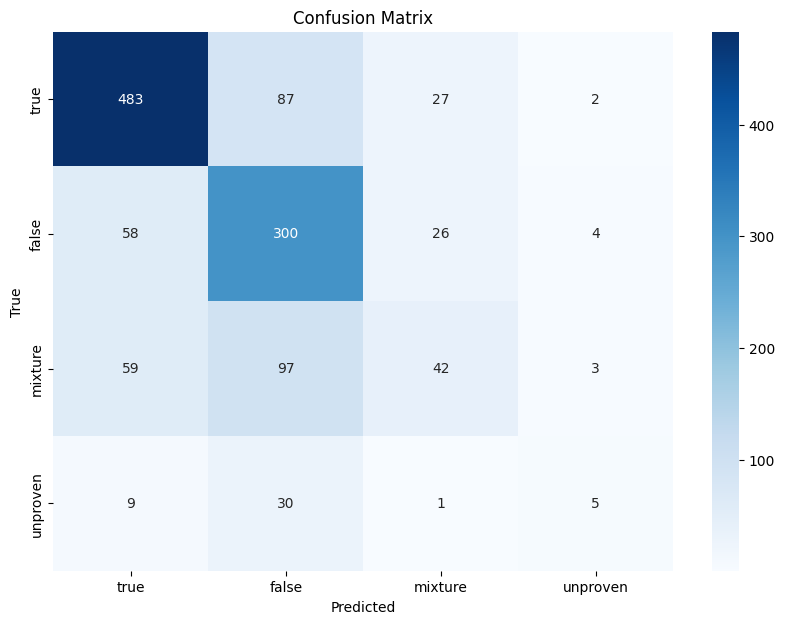

In [28]:
evaluate_model_performance(
        trainer,
        tokenized_datasets["test"],
        datasets["test"]["label"].tolist(),
        {'true': 0, 'false': 1, 'mixture': 2, 'unproven': 3}
    )

In [27]:
torch.save(trainer.model.state_dict(), 'scibert_topk.pth')

In [36]:

trainer2 = train_model_with_weights(
        tokenized_datasets["train"],
        tokenized_datasets["valid"],
        model
    )

Epoch,Training Loss,Validation Loss
1,1.034100,0.921001
2,0.848400,1.025724
3,0.660300,1.288224


In [37]:
torch.save(trainer2.model.state_dict(), 'scibert_topk_classwts.pth')

Classification Report:
               precision    recall  f1-score   support

       false       0.60      0.55      0.57       388
     mixture       0.31      0.61      0.41       201
        true       0.91      0.68      0.78       599
    unproven       0.30      0.29      0.29        45

    accuracy                           0.61      1233
   macro avg       0.53      0.53      0.51      1233
weighted avg       0.69      0.61      0.64      1233



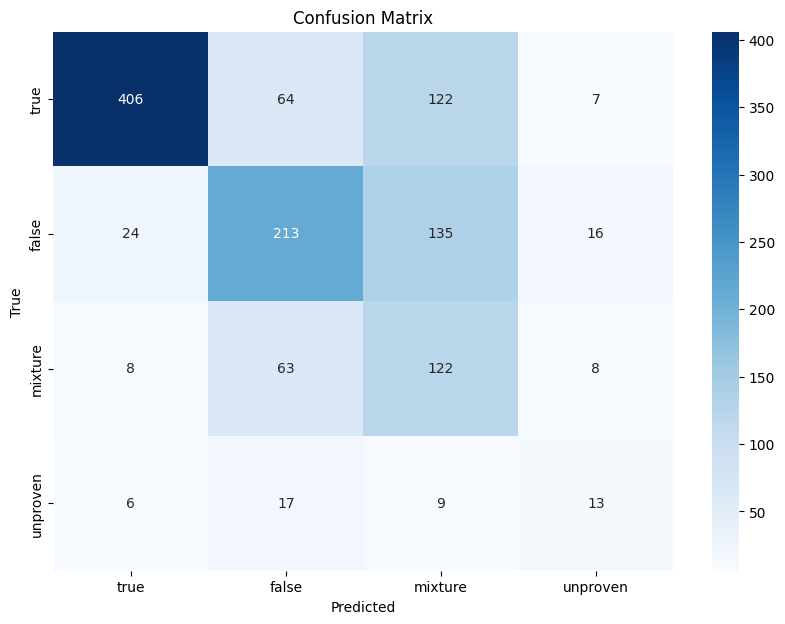

In [38]:
evaluate_model_performance(
        trainer2,
        tokenized_datasets["test"],
        datasets["test"]["label"].tolist(),
        {'true': 0, 'false': 1, 'mixture': 2, 'unproven': 3}
    )